In [1]:
# ライブラリのインストール
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [2]:
# cudaが使えるか確認
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# データの読み込み
with open('data_L=20.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# 読み込んだデータを個々の変数に分割
spin_data, temp_data = loaded_data

In [4]:
# データの形を確認
spin_data.shape , len(temp_data)

(torch.Size([25000, 20, 20]), 25000)

In [5]:
print(spin_data[10000], temp_data[10000])

tensor([[-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
         -1., -1., -1., -1., -1., -1.],
        [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1.],
        [-1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1.],
        [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1., -1.,
         -1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
         -1., -1., -1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
         -1.,  1., -1., -1.,  1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
          1.,  1., -1., -1.,  1.,  1.],
        [ 1.,  1.,  1., -1., -1., -1., -1.,  1.,

In [6]:
# サンプルデータを訓練用とテスト用に分割(5:5)
spin_train, spin_test, temp_train, temp_test = train_test_split(spin_data, temp_data, test_size=0.5)

In [7]:
# PyTorchのテンソルに変換
spin_train = torch.tensor(spin_train, dtype=torch.float32)
spin_test = torch.tensor(spin_test, dtype=torch.float32)
temp_train = torch.tensor(temp_train, dtype=torch.float32).view(-1, 1)  # (25000,) -> (25000, 1)
temp_test = torch.tensor(temp_test, dtype=torch.float32).view(-1, 1)    # (6250,) -> (6250, 1)

C:\Users\soken\AppData\Local\Temp\ipykernel_16096\3927323180.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_train = torch.tensor(spin_train, dtype=torch.float32)
C:\Users\soken\AppData\Local\Temp\ipykernel_16096\3927323180.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spin_test = torch.tensor(spin_test, dtype=torch.float32)


In [8]:
spin_train[1]

tensor([[-1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1.,
          1.,  1., -1.,  1.,  1.,  1.],
        [-1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
          1.,  1., -1., -1., -1.,  1.],
        [-1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
          1.,  1., -1., -1., -1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
          1., -1., -1., -1.,  1.,  1.],
        [-1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
         -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1., -1.,  1.,  1.],
        [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1., -1., -1.,  1.,  1.,  1.],
        [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,
         -1.,  1.,  1., -1., -1.,  1.],
        [ 1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,

In [9]:
temp_train[1]

tensor([4.])

正解データはone-hot表現にする必要がある

In [10]:
import torch

# テンソルを新しいテンソルに変換する関数を定義
def to_one_hot(data, num_classes=25):
    # one-hotベクトルの初期化
    one_hot = torch.zeros(len(data), num_classes)
    
    # 各要素を25次元のone-hotベクトルに変換
    for i, val in enumerate(data):
        index = int((val - 0.01) / 0.24)  # 正しいインデックスの計算
        one_hot[i, index] = 1.0
    
    return one_hot

# temp_train,temp_testをone-hotベクトルに変換
one_hot_temp_train = to_one_hot(temp_train, num_classes=25)
one_hot_temp_test = to_one_hot(temp_test, num_classes=25)

In [11]:
one_hot_temp_train[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0.])

In [12]:
temp_train[0]

tensor([4.7500])

In [13]:
# データセットの作成
train_dataset = TensorDataset(spin_train, one_hot_temp_train)
test_dataset = TensorDataset(spin_test, one_hot_temp_test)

In [14]:
train_dataset[0]

(tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
           1.,  1., -1., -1., -1.,  1.],
         [ 1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
          -1.,  1.,  1.,  1., -1., -1.],
         [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1., -1.],
         [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
           1.,  1., -1.,  1.,  1., -1.],
         [ 1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          -1.,  1.,  1.,  1.,  1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
          -1., -1.,  1.,  1.,  1.,  1.],
         [-1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,
           1.,  1.,  1., -1., -1., -1.],
         [-1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
           1.,  1.,  1., -1., -1., -1.],
         [-1.,  1.,  1., -1., -1

In [15]:
# 前処理を定義
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])

# データセットに前処理を適用
transformed_train_dataset = [(transform(tensor_sample), label) for tensor_sample, label in train_dataset]
transformed_test_dataset = [(transform(tensor_sample), label) for tensor_sample, label in test_dataset]

In [16]:
transformed_train_dataset[0]

(tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
           1.,  1., -1., -1., -1.,  1.],
         [ 1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
          -1.,  1.,  1.,  1., -1., -1.],
         [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
           1.,  1.,  1.,  1.,  1., -1.],
         [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1.,
           1.,  1., -1.,  1.,  1., -1.],
         [ 1., -1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          -1.,  1.,  1.,  1.,  1., -1.],
         [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
          -1., -1.,  1.,  1.,  1.,  1.],
         [-1.,  1., -1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.,
           1.,  1.,  1., -1., -1., -1.],
         [-1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
           1.,  1.,  1., -1., -1., -1.],
         [-1.,  1.,  1., -1., -1

In [17]:
# dataset内のテンソルを1次元化
transformed_train_dataset = [(sample[0].view(-1), sample[1]) for sample in transformed_train_dataset]
transformed_test_dataset = [(sample[0].view(-1), sample[1]) for sample in transformed_test_dataset]

In [18]:
transformed_train_dataset[0]

(tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
          1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
          1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,
         -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
         -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,
         -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
          1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
          1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
         -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
         -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1., -1.,
          1.,  1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1.,
         -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.

In [19]:
# DataLoaderの設定（バッチサイズ12500）
train_loader = DataLoader(transformed_train_dataset, batch_size=125, shuffle=True)
test_loader = DataLoader(transformed_test_dataset, batch_size=125)

In [20]:
x, t = next(iter(train_loader))
x.shape, t.shape

(torch.Size([125, 400]), torch.Size([125, 25]))

In [21]:
# ニューラルネットワークモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [22]:
# モデルの初期化
input_size = 400
hidden_size = 100
output_size = 25
model = NeuralNetwork(input_size, hidden_size, output_size)

model.to(device)

NeuralNetwork(
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=25, bias=True)
)

In [23]:
# モデルの中身を確認
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=25, bias=True)
)


In [24]:
# 損失関数と最適化アルゴリズムの設定
criterion = nn.CrossEntropyLoss()   # クロスエントロピー誤差を採用
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)     # Adamという最適化手法を採用,L2正則化を設定

In [25]:
# 学習の実行
num_epochs = 5000
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      # outputの一番値が大きい成分
        targets = torch.argmax(targets, dim=1)  # targetの一番値が大きい成分
        running_acc += torch.mean(pred.eq(targets).float().cpu()) # predとtargetが同じになった数の平均
        optimizer.step()
    running_loss /= len(train_loader)   # 12500個の訓練データ全体での損失関数の平均
    running_acc /= len(train_loader)    # 12500個の訓練データ全体での正解率
    train_losses.append(running_loss)
    train_accs.append(running_acc)
    #
    #   test loop
    #
    test_running_loss = 0.0
    test_running_acc = 0.0
    for test_inputs, test_targets in test_loader:
        test_inputs = test_inputs.to(device)
        test_targets = test_targets.to(device)
        test_output = model(test_inputs)
        test_loss = criterion(test_output, test_targets)
        test_running_loss += test_loss.item()
        test_pred = torch.argmax(test_output, dim=1)      # outputの一番値が大きい成分
        test_targets = torch.argmax(test_targets, dim=1)  # targetの一番値が大きい成分
        test_running_acc += torch.mean(test_pred.eq(test_targets).float().cpu()) # predとtargetの誤差が±0.5度である数の平均
    test_running_loss /= len(test_loader)   # 12500個の訓練データ全体での損失関数の平均
    test_running_acc /= len(test_loader)    # 12500個の訓練データ全体での正解率
    test_losses.append(test_running_loss)
    test_accs.append(test_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, test loss: {}, test acc: {}".format(epoch, running_loss, running_acc, test_running_loss, test_running_acc))

epoch: 0, loss: 3.2023671531677245, acc: 0.05735998600721359, test loss: 3.1977697014808655, test acc: 0.06456001102924347
epoch: 1, loss: 3.186000006198883, acc: 0.10536002367734909, test loss: 3.186171677112579, test acc: 0.08792001008987427
epoch: 2, loss: 3.16290796995163, acc: 0.14976003766059875, test loss: 3.1808966827392577, test acc: 0.08583999425172806
epoch: 3, loss: 3.1308112716674805, acc: 0.17719997465610504, test loss: 3.1729475378990175, test acc: 0.12480003386735916
epoch: 4, loss: 3.1016967725753783, acc: 0.20735998451709747, test loss: 3.1701208567619323, test acc: 0.11576002091169357
epoch: 5, loss: 3.0772941517829895, acc: 0.2306400090456009, test loss: 3.1690005826950074, test acc: 0.10872001945972443
epoch: 6, loss: 3.056162431240082, acc: 0.2555999755859375, test loss: 3.1673961162567137, test acc: 0.11312001943588257
epoch: 7, loss: 3.0395228719711302, acc: 0.269679993391037, test loss: 3.1655788946151735, test acc: 0.11800000816583633
epoch: 8, loss: 3.0260684

損失関数と正解率のグラフの作成

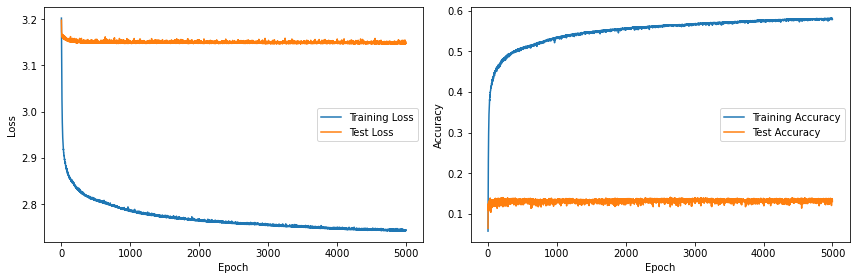

In [26]:
# グラフのプロット
plt.figure(figsize=(12, 4))

# 損失関数のグラフ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 正解率のグラフ
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

実際に予測値と正解がどうなっているか見てみる

In [27]:
print(test_pred[:100])

tensor([22,  5, 16,  9,  9, 24,  5,  5,  5, 22, 21, 10, 18,  5, 20, 16, 24,  5,
        19,  5, 15, 16,  8, 18, 17, 10,  9, 15,  5,  5,  5,  9,  3,  5,  2, 22,
         5, 13,  0, 23,  0, 22, 13,  5, 18,  5,  9, 10, 15,  7, 14, 21, 15,  7,
         5, 12,  5, 18, 16,  2,  5,  7, 22, 21,  5, 10,  5,  7,  7,  7, 15, 17,
        13, 23, 20, 13, 16,  5,  5, 14, 13,  5,  9, 20, 18, 15, 20, 18,  5,  7,
         5, 13, 14,  2,  7, 15, 10,  8, 20,  7], device='cuda:0')


In [28]:
print(test_targets[:100])

tensor([19,  1, 18, 11,  4, 17,  0,  0,  6, 17, 21, 12, 22,  3, 14, 16, 10,  6,
        23,  4, 21, 24,  9, 23, 14, 10,  9, 21,  0,  3,  6,  9, 12,  2,  5, 11,
         7, 17,  4, 12,  6, 10, 24,  5, 24,  0, 12, 10, 10,  8, 11, 22, 17,  6,
         3, 19,  9, 23, 17, 21,  1,  6, 15, 21,  3, 10,  2,  6,  9,  7, 15, 15,
        14, 23, 24, 10, 15,  0,  5, 22, 13,  1, 10, 19, 18, 12, 22, 20,  6,  7,
        12, 14, 15,  2,  6, 19,  6,  8, 10,  8], device='cuda:0')


In [29]:
test_output.shape

torch.Size([125, 25])

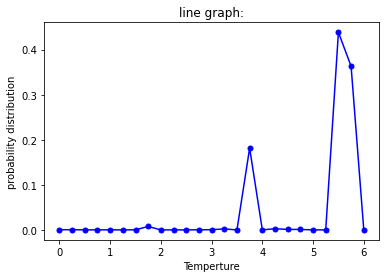

tensor(4.7500, device='cuda:0')


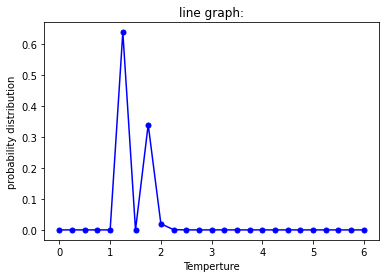

tensor(0.2500, device='cuda:0')


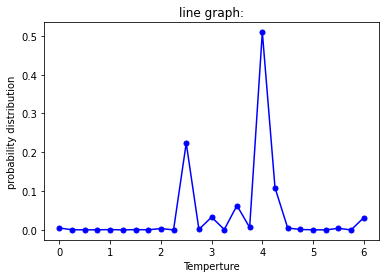

tensor(4.5000, device='cuda:0')


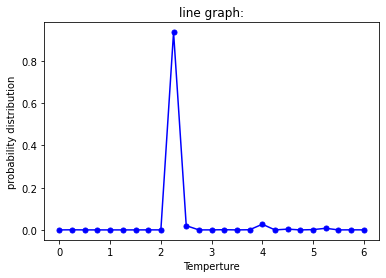

tensor(2.7500, device='cuda:0')


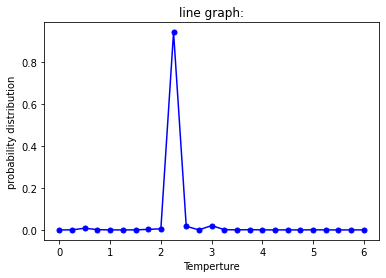

tensor(1., device='cuda:0')


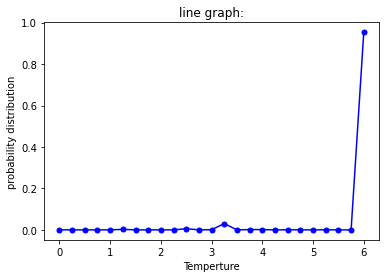

tensor(4.2500, device='cuda:0')


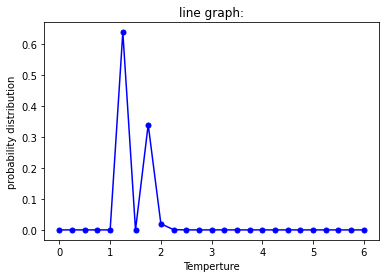

tensor(0., device='cuda:0')


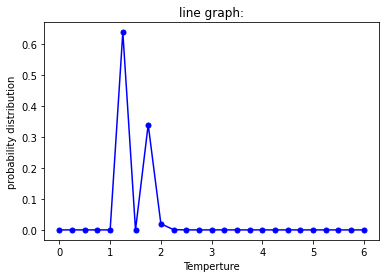

tensor(0., device='cuda:0')


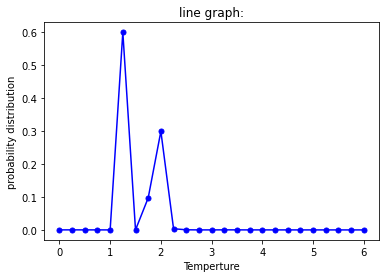

tensor(1.5000, device='cuda:0')


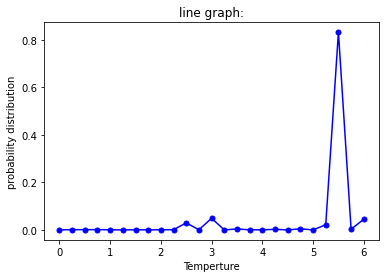

tensor(4.2500, device='cuda:0')


In [30]:
# データのx軸値
x = [i * 0.25 for i in range(25)]

for n in range(10):
    # テンソルをホストメモリにコピーしてNumpy配列に変換
    test_output_cpu = test_output[n].detach().cpu().numpy()

    # グラフを描画
    plt.plot(x, test_output_cpu, marker='o', linestyle='-', color='b', markersize=5)

    # グラフのタイトルと軸ラベルを設定
    plt.title('line graph:')
    plt.xlabel('Temperture')
    plt.ylabel('probability distribution')

    # グラフを表示
    plt.show()

    print(test_targets[n]*0.25)


モデルの保存

In [32]:
params = model.state_dict()
torch.save(params, "model_L=20.prm")